# Working with data

## Exploring One-Dimensional Data

In [1]:
import math
from collections import Counter
import random
from matplotlib import pyplot as plt
import scipy.stats
%matplotlib inline


def bucketize(point, bucket_size):
    """ floor the point to the next lower multiple of bucket size"""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points, bucket_size):
    """buckets the points and counts how many in each bucket"""
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points, bucket_size, title=""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()

For example consider two of the following datasets

In [2]:
def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    #return scipy.stats.norm(mu, sigma).pdf(p)
    return scipy.stats.norm(mu, sigma).ppf(p)


random.seed(0)

# uniform between -100 and 100
uniform = [200 * random.random() -100 for _ in range(10000)]


# normal discribution with mean 0 and standard deviation 57
normal = [57 * inverse_normal_cdf(random.random()) for _ in range(10000)]

both have means close to 0 standard deviations close to 58. However, they have very different distributions. 

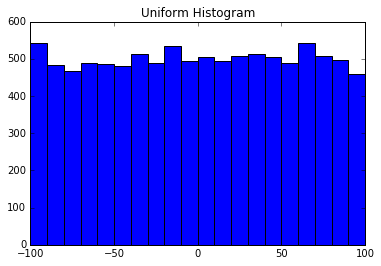

In [3]:
plot_histogram(uniform, 10, "Uniform Histogram")

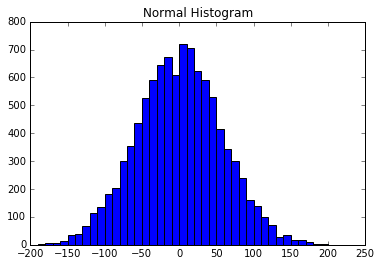

In [4]:
plot_histogram(normal, 10, "Normal Histogram")

## Two dimensions

Imagine you have a data set with two dimensions.  Of course you’d want to understand each dimension individually. 
But you probably also want to scatter the data.

In [5]:
def random_normal():
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]

ys1 = [x + random_normal()/ 2 for x in xs]
ys2 = [-x + random_normal()/ 2 for x in xs]

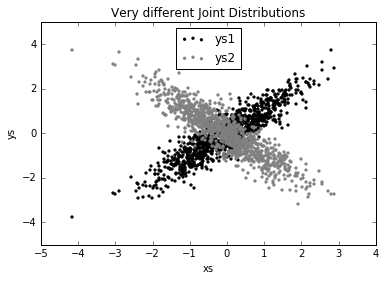

In [6]:
plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Very different Joint Distributions")
plt.show()

## Correlation

In [7]:
def correlation(x, y):
    return scipy.corrcoef(x, y)[0][1]

print(correlation(xs, ys1))

0.901049351426


In [8]:
print(correlation(xs, ys2))

-0.892098147893


## Many Dimensions

A simple approach is to look at the correlation matrix, in which the entry in row i and column j is the correlation between the ith dimension and the jth dimension of the data:

In [9]:
def shape(A):
    num_rows = len(A)
    num_cols = len(A[0]) if A else 0
    return num_rows, num_cols

def get_row(A, i):
    return A[i]

def get_column(A, j):
    return [A_i[j] for A_i in A]

def make_matrix(num_rows, num_cols, entry_fn):
    """returns a num_rows x num_cols matrix whose (i,j)-th entry is entry_fn(i, j)"""
    return [[entry_fn(i, j) for j in range(num_cols)] for i in range(num_rows)]


def correlation_matrix(data):
    """returns the num_columns x num_columns matrix whose (i, j)th entry
    is the correlation between columns i and j of data"""

    _, num_columns = shape(data)

    def matrix_entry(i, j):
        return correlation(get_column(data, i), get_column(data, j))

    return make_matrix(num_columns, num_columns, matrix_entry)


num_points = 100

def random_row():
    row = [None, None, None, None]
    row[0] = random_normal()
    row[1] = -5 * row[0] + random_normal()
    row[2] = row[0] + row[1] + 5 * random_normal()
    row[3] = 6 if row[2] > -2 else 0
        
    return row
    
random.seed(0)
data = [random_row() for _ in range(num_points)]

correlation_matrix(data)

[[1.0, -0.98113582044316994, -0.66175016453730051, -0.51732254119933652],
 [-0.98113582044316994, 1.0, 0.68181915287505246, 0.54211560423323668],
 [-0.66175016453730051, 0.68181915287505246, 1.0, 0.7461445632361452],
 [-0.51732254119933652, 0.54211560423323668, 0.7461445632361452, 1.0]]

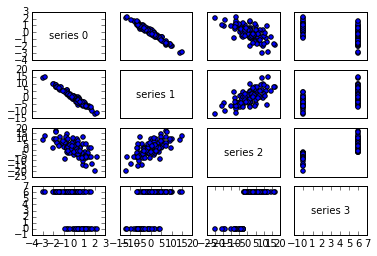

In [10]:
# then plot it

_, num_columns = shape(data)
fig, ax = plt.subplots(num_columns, num_columns)

for i in range(num_columns):
    for j in range(num_columns):

        # scatter column_j on the x-axis vs column_i on the y-axis
        if i != j: 
            ax[i][j].scatter(get_column(data, j), get_column(data, i))

        # unless i == j, in which case show the series name
        else: 
            ax[i][j].annotate("series " + str(i), (0.5, 0.5), xycoords='axes fraction', ha="center", va="center")

        # then hide axis labels except left and bottom charts
        if i < num_columns - 1: ax[i][j].xaxis.set_visible(False)
        if j > 0: ax[i][j].yaxis.set_visible(False)

# fix the bottom right and top left axis labels, which are wrong because
# their charts only have text in them
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())

plt.show()

# Cleaning and Munging

In [11]:
def try_or_none(f):
    """wraps f to return None if f raises an exception. It assumes f taks only one input. """
    
    def f_or_none(x):
        try:
            return f(x)
        except:
            return None
    return f_or_none

def parse_row(input_row, parsers):
    """given a list of parsers (some of which may be None)
    apply the appropriate one to each element of the input row"""
    
    return [try_or_none(parser)(value) if parser is not None else value for value, parser in zip(input_row, parsers)]

def parse_row_with(reader, parsers):
    """wrap a reader to apply parsers to each of its rows"""
    
    for row in reader:
        yield parse_row(row, parsers)

In [12]:
import dateutil.parser
import csv

data = []

with open("comma_delimited_stock_prices.csv", 'r') as f:
    reader = csv.reader(f)
    for line in parse_row_with(reader, [dateutil.parser.parse, None, float]):
        data.append(line)

In [13]:
for row in data:
    if not any(x is None for x in row):
        print(row)

[datetime.datetime(2014, 6, 20, 0, 0), 'AAPL', 90.91]
[datetime.datetime(2014, 6, 20, 0, 0), 'MSFT', 41.68]
[datetime.datetime(3014, 6, 20, 0, 0), 'FB', 64.5]
[datetime.datetime(2014, 6, 19, 0, 0), 'AAPL', 91.86]
[datetime.datetime(2014, 6, 19, 0, 0), 'FB', 64.34]


In [14]:
def try_parse_field(field_name, value, parser_dict):
    """try to parse value using the appropriate function from parser_dict"""
    parser = parser_dict.get(field_name)
    # None if no such entry
    if parser is not None:
        return try_or_none(parser)(value)
    else:
        return value

def parse_dict(input_dict, parser_dict):
    return { field_name : try_parse_field(field_name, value, parser_dict) 
            for field_name, value in input_dict.iteritems() 
           }

# Manipulating Data

In [15]:
data_dict = [{'date':row[0], 'symbol':row[1], 'closing_price':row[2]} 
             for row in data if not any(x is None for x in row)]

In [16]:
data_dict

[{'closing_price': 90.91,
  'date': datetime.datetime(2014, 6, 20, 0, 0),
  'symbol': 'AAPL'},
 {'closing_price': 41.68,
  'date': datetime.datetime(2014, 6, 20, 0, 0),
  'symbol': 'MSFT'},
 {'closing_price': 64.5,
  'date': datetime.datetime(3014, 6, 20, 0, 0),
  'symbol': 'FB'},
 {'closing_price': 91.86,
  'date': datetime.datetime(2014, 6, 19, 0, 0),
  'symbol': 'AAPL'},
 {'closing_price': 64.34,
  'date': datetime.datetime(2014, 6, 19, 0, 0),
  'symbol': 'FB'}]

In [17]:
max_appl_price = max([row['closing_price'] for  row in data_dict if row['symbol']=='AAPL'])
print("Max appl price ", max_appl_price)

Max appl price  91.86


In [18]:
from collections import defaultdict

by_symbol = defaultdict(list)

for row in data_dict:
    by_symbol[row['symbol']].append(row)
    
by_symbol

defaultdict(<class 'list'>, {'MSFT': [{'closing_price': 41.68, 'symbol': 'MSFT', 'date': datetime.datetime(2014, 6, 20, 0, 0)}], 'AAPL': [{'closing_price': 90.91, 'symbol': 'AAPL', 'date': datetime.datetime(2014, 6, 20, 0, 0)}, {'closing_price': 91.86, 'symbol': 'AAPL', 'date': datetime.datetime(2014, 6, 19, 0, 0)}], 'FB': [{'closing_price': 64.5, 'symbol': 'FB', 'date': datetime.datetime(3014, 6, 20, 0, 0)}, {'closing_price': 64.34, 'symbol': 'FB', 'date': datetime.datetime(2014, 6, 19, 0, 0)}]})

In [19]:
max_price_by_symbol = {symbol:max( row['closing_price'] for row in grouped_row) 
                       for symbol, grouped_row in by_symbol.items()}

print("Max price by symbol ", max_price_by_symbol)

Max price by symbol  {'MSFT': 41.68, 'AAPL': 91.86, 'FB': 64.5}


In [20]:
def picker(field_name):
    """returns a function that picks a field out of a dict"""
    return lambda row: row[field_name]

def pluck(field_name, rows):
    """turn a list of dicts into the list of field name values """
    return map(picker(field_name), rows)

def group_by(grouper, rows, value_transform=None):
    # key is output of grouper, value is list of rows
    
    grouped = defaultdict(list)
    
    for row in rows:
        grouped[grouper(row)].append(row)
        
    if value_transform is None:
        return grouped
    
    return {key: value_transform(rows) for key, rows in grouped.items()}

In [21]:
max_price_by_symbol = group_by(picker("symbol"), data_dict, lambda rows: max(pluck('closing_price', rows)))
max_price_by_symbol

{'AAPL': 91.86, 'FB': 64.5, 'MSFT': 41.68}

## what are the largest and smallest one-day percent changes in our data set?

The percent change is price_today / price_yesterday - 1

In [22]:
def percent_price_change(yesterday, today):
    return today['closing_price'] / yesterday['closing_price'] -1 

def day_over_day_changes(grouped_rows):
    # sort the rows by date
    ordered = sorted(grouped_rows, key=picker("date"))
    # zip with an offset to get pairs of consecutive days
    return [{ "symbol" : today["symbol"], "date" : today["date"], "change" : percent_price_change(yesterday, today) } 
            for yesterday, today in zip(ordered, ordered[1:])]



In [23]:
# key is symbol, value is list of "change" dicts
changes_by_symbol = group_by(picker("symbol"), data_dict, day_over_day_changes)
changes_by_symbol

{'AAPL': [{'change': -0.0103418245155672,
   'date': datetime.datetime(2014, 6, 20, 0, 0),
   'symbol': 'AAPL'}],
 'FB': [{'change': 0.0024867889337891746,
   'date': datetime.datetime(3014, 6, 20, 0, 0),
   'symbol': 'FB'}],
 'MSFT': []}

In [24]:
# collect all "change" dicts into one big list
all_changes = [change for changes in changes_by_symbol.values() for change in changes]
all_changes

[{'change': -0.0103418245155672,
  'date': datetime.datetime(2014, 6, 20, 0, 0),
  'symbol': 'AAPL'},
 {'change': 0.0024867889337891746,
  'date': datetime.datetime(3014, 6, 20, 0, 0),
  'symbol': 'FB'}]

In [25]:
max(all_changes, key=picker("change"))

{'change': 0.0024867889337891746,
 'date': datetime.datetime(3014, 6, 20, 0, 0),
 'symbol': 'FB'}

In [26]:
min(all_changes, key=picker("change"))

{'change': -0.0103418245155672,
 'date': datetime.datetime(2014, 6, 20, 0, 0),
 'symbol': 'AAPL'}

We can now use this new all_changes data set to find which month is the best to invest in tech stocks. First we group the changes by month; then we compute the overall change within each group.

In [27]:
from functools import partial, reduce

# to combine percent changes, we add 1 to each, multiply them, and subtract 1
# for instance, if we combine +10% and -20%, the overall change is
# (1 + 10%) * (1 - 20%) - 1 = 1.1 * .8 - 1 = -12%
def combine_pct_changes(pct_change1, pct_change2):
    return (1 + pct_change1) * (1 + pct_change2) - 1

def overall_change(changes):
    return reduce(combine_pct_changes, pluck("change", changes))

overall_change_by_month = group_by(lambda row: row['date'].month, all_changes, overall_change)

overall_change_by_month

{6: -0.007880753516538497}

# Rescaling

Many techniques are sensitive to the scale of your data.

For example, imagine that you
have a data set consisting of the heights and weights of hundreds of data scientists,
and that you are trying to identify clusters of body sizes.

|Person|Height(inches)|Height(cm)|Weight(pounds)|
|------|--------------|----------|--------------|
|A     |      63      |    160   |     150      |
|B     |      67      |    120.2 |     160      |
|C     |      70      |    177.8 |     171      |

We need some notion of distance between points. Let's try with **Euclidean** distance

In [33]:
from scipy.spatial import distance

a_to_b = distance.euclidean([63, 150],[67, 160])
a_to_c = distance.euclidean([63, 150],[70, 171])
b_to_c = distance.euclidean([67, 160],[70, 171])

print("A to B ", a_to_b)
print("A to C ", a_to_c)
print("B to C ", b_to_c)

A to B  10.7703296143
A to C  22.1359436212
B to C  11.401754251


__B’s nearest neighbor is A__

If we measure height in centimeters:

In [34]:
a_to_b = distance.euclidean([160, 150],[170.2, 160])
a_to_c = distance.euclidean([160, 150],[178.8, 171])
b_to_c = distance.euclidean([170.2, 160],[177.8, 171])

print("A to B ", a_to_b)
print("A to C ", a_to_c)
print("B to C ", b_to_c)

A to B  14.284257068535268
A to C  28.185812033716545
B to C  13.370115930686628


__B’s nearest neighbor is instead C__

For this reason, when dimensions aren’t comparable with one another, we will sometimes rescale our data so that each dimension has mean 0 and standard deviation 1.

In [59]:
def dot(v, w):
    """v_1 * w_1 + ... + v_n * w_n"""
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def mean(x):
    return sum(x) / len(x)

def de_mean(x):
    """translate x by subtracting its mean (so the result has mean 0)"""
    x_bar = mean(x)
    return [x_i - x_bar for x_i in x]

def variance(x):
    """assumes x has at least two elements"""
    n = len(x)
    deviations = de_mean(x)
    return sum_of_squares(deviations) / (n - 1)

def standard_deviation(x):
    return math.sqrt(variance(x))

def shape(A):
    num_rows = len(A)
    num_cols = len(A[0]) if A else 0
    return num_rows, num_cols

def get_row(A, i):
    return A[i]

def get_column(A, j):
    return [A_i[j] for A_i in A]

def make_matrix(num_rows, num_cols, entry_fn):
    """returns a num_rows x num_cols matrix
    whose (i,j)-th entry is entry_fn(i, j)"""
    return [[entry_fn(i, j) for j in range(num_cols)]
            for i in range(num_rows)]

def scale(data_matrix):
    """return the means and standard deviations of each columns"""
    _, num_cols = shape(data_matrix)
    means = [mean(get_column(data_matrix, j)) for j in range(num_cols)]
    stddevs = [standard_deviation(get_column(data_matrix,j)) for j in range(num_cols)]
    
    return means, stddevs


def rescale(data_matrix):
    """rescales the input data so that each column has mean 0 and standard deviation 1 
    leaves alone columns with no deviation"""
    
    means, stdevs = scale(data_matrix)

    def rescaled(i, j):
        if stdevs[j] > 0:
            return (data_matrix[i][j] - means[j]) / stdevs[j]

        return data_matrix[i][j]

    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows, num_cols, rescaled)
    

data = [[63, 160, 150], [67, 170.2, 160], [70, 177.8, 171],]

print(scale(data))

rescale_data = rescale(data)
num_rows, num_cols = shape(rescale_data)
rescale_data

([66.66666666666667, 169.33333333333334, 160.33333333333334], [3.511884584284246, 8.931591870060647, 10.503967504392486])


[[-1.0440737953277504, -1.0449798276855173, -0.9837552647618352],
 [0.09491579957524855, 0.09703384114222419, -0.03173404079876975],
 [0.9491579957524977, 0.9479459865432901, 1.0154893055606022]]

In [62]:
a_to_b = distance.euclidean(rescale_data[0][1:], rescale_data[1][1:])
a_to_c = distance.euclidean(rescale_data[0][1:], rescale_data[2][1:])
b_to_c = distance.euclidean(rescale_data[1][1:], rescale_data[2][1:])

print("A to B ", a_to_b)
print("A to C ", a_to_c)
print("B to C ", b_to_c)

A to B  1.4867883610875934
A to C  2.8228942865405537
B to C  1.349343624267431


In [63]:
a_to_b = distance.euclidean([rescale_data[0][0],rescale_data[0][2]], [rescale_data[1][0],rescale_data[1][2]])
a_to_c = distance.euclidean([rescale_data[0][0],rescale_data[0][2]], [rescale_data[2][0],rescale_data[2][2]])
b_to_c = distance.euclidean([rescale_data[1][0],rescale_data[1][2]], [rescale_data[2][0],rescale_data[2][2]])

print("A to B ", a_to_b)
print("A to C ", a_to_c)
print("B to C ", b_to_c)

A to B  1.4844668093876099
A to C  2.823110310444266
B to C  1.3514460651057634


Now in both cases B's nearest neighbor is C

# Dimensionality Reduction

TODO